# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from skpp import ProjectionPursuitRegressor

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [3]:
# Read out CSV

df = pd.read_csv('UCI_Credit_Card.csv', sep=',')

In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [5]:
df['Unnamed: 0']

KeyError: 'Unnamed: 0'

In [9]:
df.shape

(20468, 114)

In [10]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [6]:
df_labels = df['default.payment.next.month']
df.drop(['default.payment.next.month'],axis = 1,inplace = True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

## Quantum Approaches

In [13]:
np.unique(df_labels)

array([0, 1])

In [16]:
np.shape(X_train)

(16374, 93)

In [8]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline', opt_level='medium').fit(X_train, y_train)

In [9]:
# SKPP validate transformation (using train fit)
x_train_skpp = skpp.transform(X_train)
x_test_skpp = skpp.transform(X_test)

In [10]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [11]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
X_train_skpp_norm = std_scale.transform(x_train_skpp)
x_test_skpp_norn = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [12]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

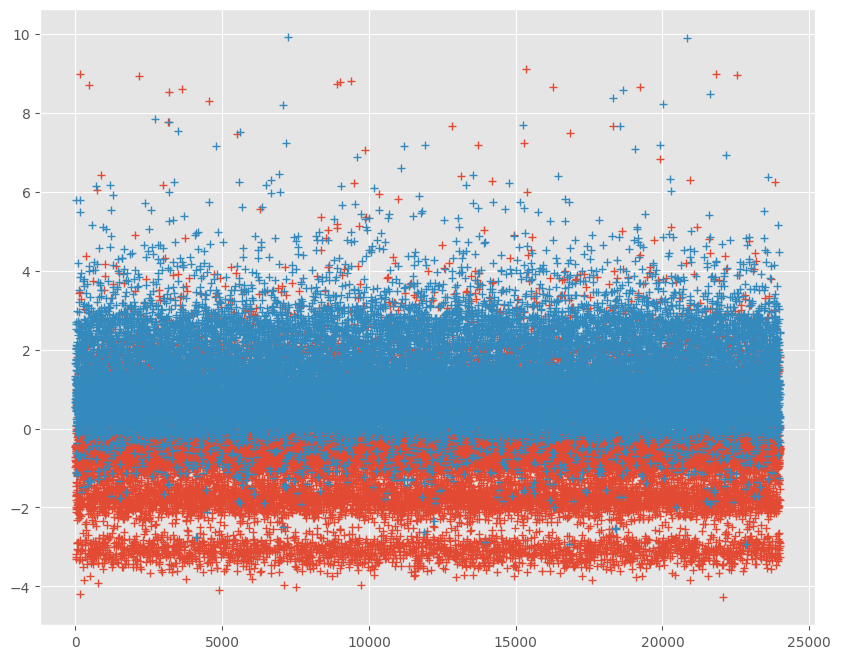

In [13]:
plt.figure(figsize=(10,8))
plt.plot(x_train_skpp, '+')


## Split train test 

In [14]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     X_train_skpp_norm, y_train, test_size=0.2, random_state=22)

# Normalize

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [15]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [17]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [19]:
#result_predict = svc.predict(sample_test)

In [ ]:
print(metrics.classification_report(label_test,result_predict))

In [20]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [21]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('qsvc', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [22]:
df_results = pd.DataFrame()

In [23]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

100%|████████████████████████████████████████████| 6/6 [50:33<00:00, 505.52s/it]

               fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)        0.12        0.14           77.33        12.08    19.78   
LR std (%)         0.09        0.03           20.21         7.66    10.81   
KNN mean (%)       0.03        0.20           55.84        33.11    39.96   
KNN std (%)        0.01        0.02           16.82        15.39    13.59   
CART mean (%)      0.12        0.11           36.60        36.91    35.69   
CART std (%)       0.01        0.01           10.04        13.19     8.78   
NB mean (%)        0.02        0.11           64.69        29.33    39.30   
NB std (%)         0.00        0.01           14.15         9.80     9.75   
SVM mean (%)       0.57        0.21           68.08        24.33    34.50   
SVM std (%)        0.03        0.01           13.09        11.98    13.06   
qsvc mean (%)  25148.00     5181.01            0.00         0.00     0.00   
qsvc std (%)     600.76       93.80            0.00         0.00     0.00   

In [24]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
LR mean (%),0.12,0.14,77.33,12.08,19.78,78.25,23.12,55.38
LR std (%),0.09,0.03,20.21,7.66,10.81,5.04,9.70,3.61
KNN mean (%),0.03,0.20,55.84,33.11,39.96,77.88,30.26,62.63
KNN std (%),0.01,0.02,16.82,15.39,13.59,6.07,16.12,7.85
CART mean (%),0.12,0.11,36.60,36.91,35.69,70.00,17.15,58.78
CART std (%),0.01,0.01,10.04,13.19,8.78,4.81,12.11,6.91
NB mean (%),0.02,0.11,64.69,29.33,39.30,79.38,33.01,62.13
NB std (%),0.00,0.01,14.15,9.80,9.75,4.65,10.61,4.98
SVM mean (%),0.57,0.21,68.08,24.33,34.50,79.50,31.25,60.44
SVM std (%),0.03,0.01,13.09,11.98,13.06,4.85,12.17,5.85


## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [24]:
%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

#backend = qiskit.Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend("qasm_simulator")
# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



AttributeError: 'QuantumInstance' object has no attribute 'evaluate'

In [1]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [25]:
from pennylane import numpy as np

In [26]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [27]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [28]:
circuit(weights_init, sample_train[0])

tensor(-0.08462787, requires_grad=True)

In [29]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [30]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [31]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [32]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [33]:
pd.Series(label_test).value_counts()

0    160
1     40
Name: default.payment.next.month, dtype: int64

In [34]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.38868453, requires_grad=True), tensor(0.17975752, requires_grad=True)], Y = -1
X = [tensor(0.09067561, requires_grad=True), tensor(-0.16492248, requires_grad=True)], Y = -1
X = [tensor(1.74759435, requires_grad=True), tensor(0.31647715, requires_grad=True)], Y = -1
X = [tensor(-1.56054953, requires_grad=True), tensor(-0.75105161, requires_grad=True)], Y =  1
X = [tensor(-0.01448404, requires_grad=True), tensor(-0.3930499, requires_grad=True)], Y = -1


In [35]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [36]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.9075557 | f1: 0.4317719 
Iter:     2 | Cost: 0.7421187 | f1: 0.4067797 
Iter:     3 | Cost: 0.7006192 | f1: 0.3676012 
Iter:     4 | Cost: 0.7234062 | f1: 0.3620178 
Iter:     5 | Cost: 0.7439346 | f1: 0.3705882 
Iter:     6 | Cost: 0.6702134 | f1: 0.3507463 
Iter:     7 | Cost: 0.6798288 | f1: 0.3538462 
Iter:     8 | Cost: 0.7051294 | f1: 0.3636364 
Iter:     9 | Cost: 0.7079168 | f1: 0.3571429 
Iter:    10 | Cost: 0.6869694 | f1: 0.3557312 
Iter:    11 | Cost: 0.6794208 | f1: 0.3636364 
Iter:    12 | Cost: 0.7091197 | f1: 0.3586626 
Iter:    13 | Cost: 0.7242269 | f1: 0.3614458 
Iter:    14 | Cost: 0.7078384 | f1: 0.3696970 
Iter:    15 | Cost: 0.7040779 | f1: 0.3507692 
Iter:    16 | Cost: 0.7292538 | f1: 0.3406940 
Iter:    17 | Cost: 0.7540777 | f1: 0.3269962 
Iter:    18 | Cost: 0.7751080 | f1: 0.3252033 
Iter:    19 | Cost: 0.7442091 | f1: 0.3306452 
Iter:    20 | Cost: 0.7144367 | f1: 0.3306452 
Iter:    21 | Cost: 0.6819263 | f1: 0.3319838 
Iter

In [37]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [38]:
pd.Series(Yte).value_counts()

-1.0    160
 1.0     40
dtype: int64

In [39]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.848536623277729, Accuracy: 59.0%


In [40]:
print(metrics.classification_report(Yte,predictions))

              precision    recall  f1-score   support

        -1.0       0.79      0.67      0.72       160
         1.0       0.17      0.28      0.21        40

    accuracy                           0.59       200
   macro avg       0.48      0.47      0.47       200
weighted avg       0.66      0.59      0.62       200



In [41]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    ''')



    Precision: 27.5%
    Recall: 17.19%
    f1: 21.15%
    Accuracy: 59.0%
    Matthew corcorref: -4.82%
    Balanced accuracy: 47.93%
    


In [42]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = accuracy(Y, predictions)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 1.1718495 | Accuracy: 0.6137500 
New best
Iter:     2 | Cost: 0.9999910 | Accuracy: 0.6287500 
New best
Iter:     3 | Cost: 0.8170132 | Accuracy: 0.7087500 
New best
Iter:     4 | Cost: 0.7274715 | Accuracy: 0.7350000 
New best
Iter:     5 | Cost: 0.7353281 | Accuracy: 0.7475000 
New best
Iter:     6 | Cost: 0.7817120 | Accuracy: 0.7537500 
New best
Iter:     7 | Cost: 0.8190967 | Accuracy: 0.7562500 
Iter:     8 | Cost: 0.8232952 | Accuracy: 0.7525000 
New best
Iter:     9 | Cost: 0.7828787 | Accuracy: 0.7650000 
New best
Iter:    10 | Cost: 0.7096655 | Accuracy: 0.7750000 
Iter:    11 | Cost: 0.7098025 | Accuracy: 0.7712500 
Iter:    12 | Cost: 0.7470942 | Accuracy: 0.7700000 
Iter:    13 | Cost: 0.7670781 | Accuracy: 0.7725000 
Iter:    14 | Cost: 0.7834860 | Accuracy: 0.7612500 
Iter:    15 | Cost: 0.7362662 | Accuracy: 0.7625000 
Iter:    16 | Cost: 0.7204685 | Accuracy: 0.7662500 
Iter:    17 | Cost: 0.7027118 | Accuracy: 0.7650000 
New best
Iter:    

In [43]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5771970542537855, Accuracy: 80.0%


In [44]:
print(metrics.classification_report(Yte, predictions))

              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89       160
         1.0       0.00      0.00      0.00        40

    accuracy                           0.80       200
   macro avg       0.40      0.50      0.44       200
weighted avg       0.64      0.80      0.71       200



In [45]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 0.0%
    Recall: 0.0%
    f1: 0.0%
    Accuracy: 80.0%
    Balanced accuracy: 80.0%
    Matthew corcorref: 0.0%
    
